# Library

In [2]:
import pandas as pd
import pandahouse
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import causalimpact
from causalimpact import CausalImpact

import tensorflow_probability as tfp
from causalimpact.misc import standardize

# Connection to server database

In [171]:
# connect = {'host':'https://clickhouse.lab.karpov.courses',
#            'password':'dpo_python_2020',
#            'user':'student',
#            'database':'simulator_20240120'}

# # load
# query = '''select t1.day day, likes, views, users_feed, new_feed_users, 
#                    users_mess, usersWithLikes_share,
#                    posts, new_posts, CTR
#             from
#                 (select toDate(time) day,
#                       countIf(action = 'like') likes,
#                       countIf(action = 'view') views,
#                       countIf(action = 'like')/countIf(action = 'view') CTR,
#                       uniqExact(user_id) users_feed,
#                       countIf(distinct user_id, action = 'like')/uniqExact(user_id) usersWithLikes_share,
#                       uniqExact(post_id) posts
#                 from simulator_20240120.feed_actions
#                 where toDate(time) >= '2023-12-02' and toDate(time) < '2024-01-26'
#                 group by day) t1
#             join
#                 (select toDate(time) day,
#                         uniqExact(user_id) users_mess
#                 from simulator_20240120.message_actions
#                 where toDate(time) >= '2023-12-02' and toDate(time) < '2024-01-26'
#                 group by day) t2
#             on t1.day = t2.day
#             join
#                 (select toDate(start_time) start_day_u,
#                        count(user_id) new_feed_users
#                 from
#                     (select user_id, min(toDateTime(time)) as start_time
#                     from simulator_20240120.feed_actions
#                     group by user_id
#                     having start_time >= '2023-12-02 00:00:00' and start_time < '2024-01-26 00:00:00')
#                 group by start_day_u) t3
#             on t1.day = t3.start_day_u
#             join
#                 (select toDate(start_time) start_day_p, 
#                         count(post_id) new_posts
#                 from
#                     (select post_id, min(toDateTime(time)) as start_time
#                     from simulator_20240120.feed_actions
#                     group by post_id
#                     having start_time >= '2023-12-02 00:00:00' and start_time < '2024-01-26 00:00:00')
#                 group by start_day_p) t4
#             on t1.day = t4.start_day_p
#             order by day'''

# activity = pandahouse.read_clickhouse(query, connection=connect)
# activity['ER'] = (activity['likes'] / activity['posts']) / activity['users_feed']


# # save
# activity.to_csv('data/activity.csv', index=False)

In [3]:
#load
activity = pd.read_csv('data/activity.csv')
activity.head(3)

,day,likes,views,users_feed,new_feed_users,users_mess,usersWithLikes_share,posts,new_posts,CTR,ER
0,2023-12-02,1560,7603,878,878,234,0.677677,89,89,0.205182,0.019964
1,2023-12-03,12816,62770,2238,1819,623,0.962913,178,97,0.204174,0.032172
2,2023-12-04,20958,105526,3105,1849,522,0.981965,191,61,0.198605,0.035339


# First analysis

Main metrics for tracking the expected effect:
1. increasing CTR
2. increasing ER (Engagement Rate)
3. increasing active users count
4. increasing posts count, which was viewed or liked
5. increasing average user activity (likes)

What can we say about the first visual assessment of two periods?
Which metrics would we use at causal impact analysis and which don't show any effect?

 Before the flash mob: from 2024-01-05 to 2024-01-11 

 After the flash mob: from 2024-01-12 to 2024-01-18 



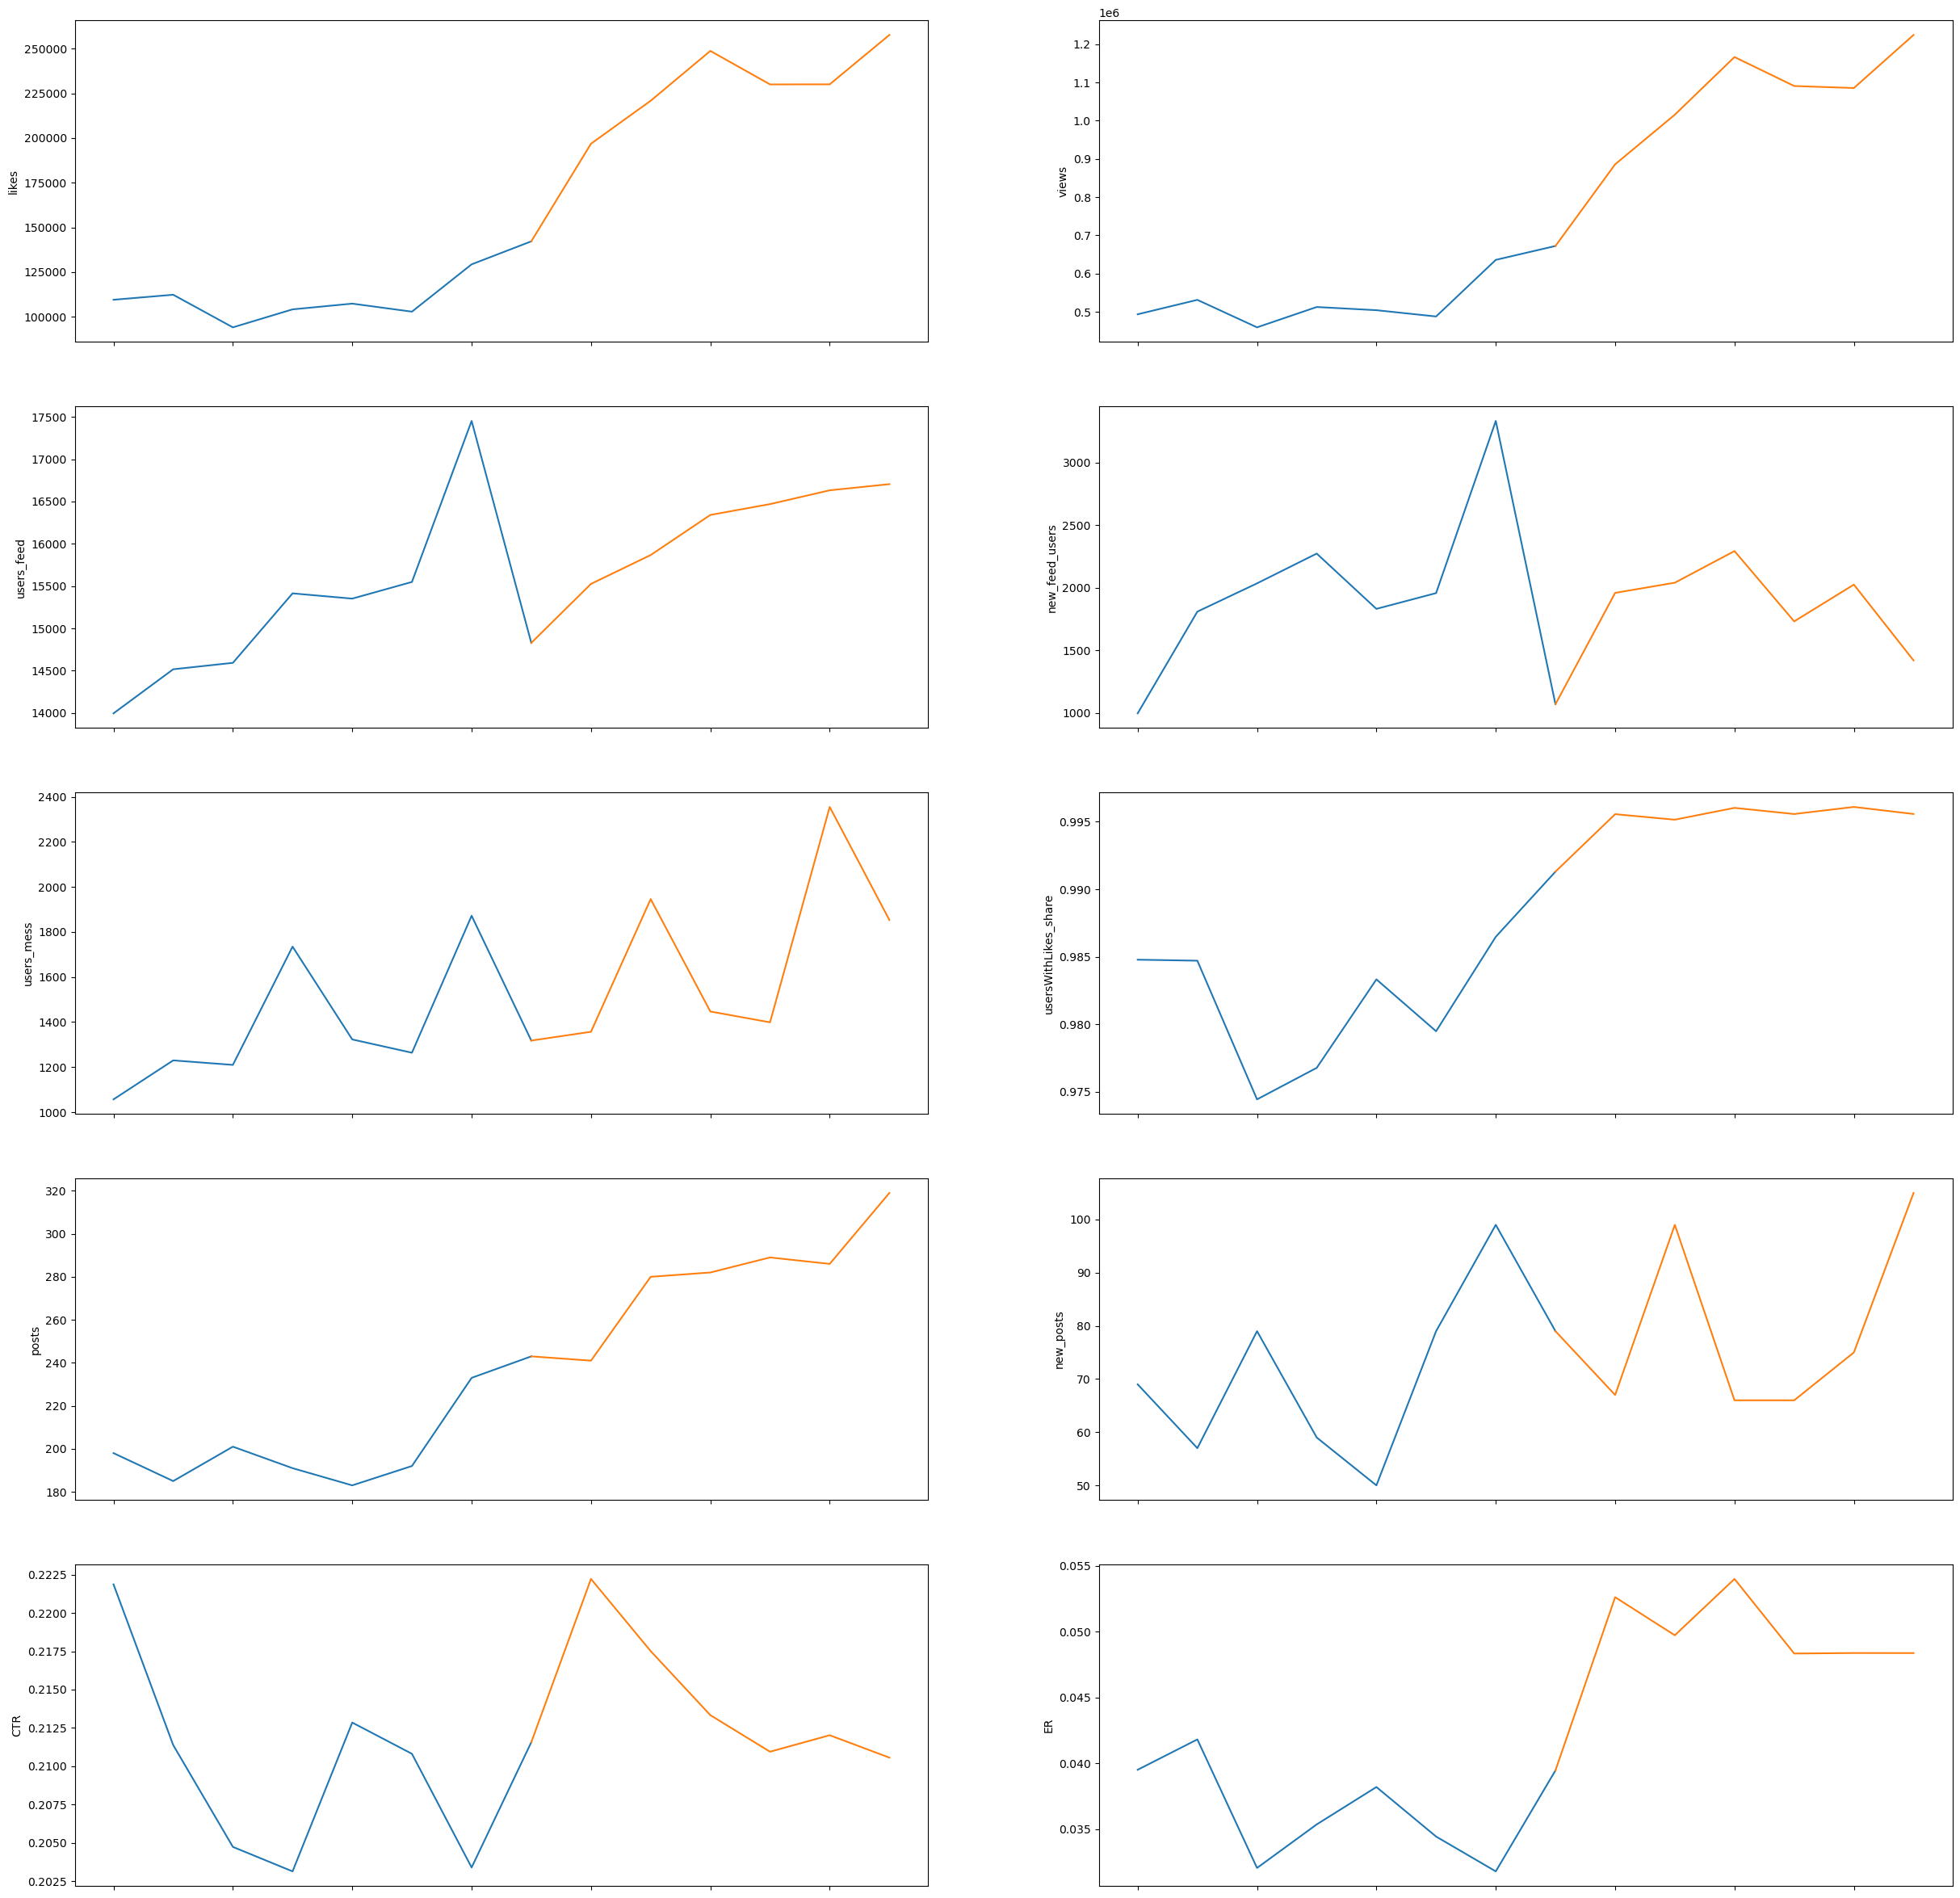

In [160]:
print('\033[1;34m Before the flash mob: from 2024-01-05 to 2024-01-11 \n')
print('\033[1;33m After the flash mob: from 2024-01-12 to 2024-01-18 \n')

prev_ = activity[(activity['day'] >= '2024-01-05') & (activity['day'] < '2024-01-13')]
in_ = activity[(activity['day'] >= '2024-01-12') & (activity['day'] <= '2024-01-18')]
metrics = activity.columns.tolist()[1:]

fig,ax = plt.subplots(5, 2, figsize=(30,30))
row = 0
column = 0

for i in metrics:
    if row <= 4 and column <= 1:
        sns.lineplot(prev_[i], ax=ax[row][column])
        sns.lineplot(in_[i], ax=ax[row][column])
        ax[row][column].set_xticklabels('')
        column += 1
    else:
        row += 1
        column = 0
        sns.lineplot(prev_[i], ax=ax[row][column])
        sns.lineplot(in_[i], ax=ax[row][column])
        ax[row][column].set_xticklabels('')
        column += 1

plt.show()

By first view the effect wasn't noticeable with new users amount and new posts amount.

And it seems like flash mob influence on DAU at messanger service.


# Causal impact analysis

There was a new marketing campaign at 2024.01.11 which bring a lot of new users from advertising traffic - they were unrelevant

In [187]:
# solve this anomaly
prev_day = activity[activity['day'].str.contains('2024-01-10')]['new_feed_users'].sum()
marketing_day = activity[activity['day'].str.contains('2024-01-11')]['new_feed_users'].sum()
next_dat = activity[activity['day'].str.contains('2024-01-12')]['new_feed_users'].sum()
print(prev_day, marketing_day, next_dat)

print('Average value at 01.11.2024 = ', (prev_day+next_dat)/2)
print('Difference = ', marketing_day - (prev_day+next_dat)/2)

#That's the bad way to solve the anomalies problems, but we use it
to_minus = (marketing_day - (prev_day+next_dat)/2)
to_minus = to_minus.astype(int)

activity.loc[activity['day'] == '2024-01-11', 
             'new_feed_users'] = activity[activity['day'] == '2024-01-11']['new_feed_users'] - to_minus

1957 3333 1069
Average value at 01.11.2024 =  1513.0
Difference =  1820.0


First causal impact analysis

In [190]:
activity_causal = activity.set_index('day')

In [165]:
# correlation test
activity_causal.corr()

,likes,views,users_feed,new_feed_users,users_mess,usersWithLikes_share,posts,new_posts,CTR,ER
likes,1.000000,0.999001,0.786631,-0.372995,0.776469,0.354407,0.742876,0.067959,0.533295,0.796929
views,0.999001,1.000000,0.787742,-0.368299,0.781219,0.357607,0.753382,0.070332,0.500898,0.783456
users_feed,0.786631,0.787742,1.000000,0.111371,0.793580,0.392514,0.367289,-0.044221,0.567954,0.478210
new_feed_users,-0.372995,-0.368299,0.111371,1.000000,-0.145980,-0.398611,-0.377203,0.017658,-0.267606,-0.325466
users_mess,0.776469,0.781219,0.793580,-0.145980,1.000000,0.289345,0.497038,-0.042390,0.369327,0.473312
usersWithLikes_share,0.354407,0.357607,0.392514,-0.398611,0.289345,1.000000,0.537618,-0.117002,0.148204,0.516116
posts,0.742876,0.753382,0.367289,-0.377203,0.497038,0.537618,1.000000,0.308665,0.068629,0.606702
new_posts,0.067959,0.070332,-0.044221,0.017658,-0.042390,-0.117002,0.308665,1.000000,-0.074750,-0.215944
CTR,0.533295,0.500898,0.567954,-0.267606,0.369327,0.148204,0.068629,-0.074750,1.000000,0.583792
ER,0.796929,0.783456,0.478210,-0.325466,0.473312,0.516116,0.606702,-0.215944,0.583792,1.000000


Let's analyse:
1. Previous period - historical data before the flash mob
2. Analisys period - the flash mob and the next week (to assess further impact)

likes


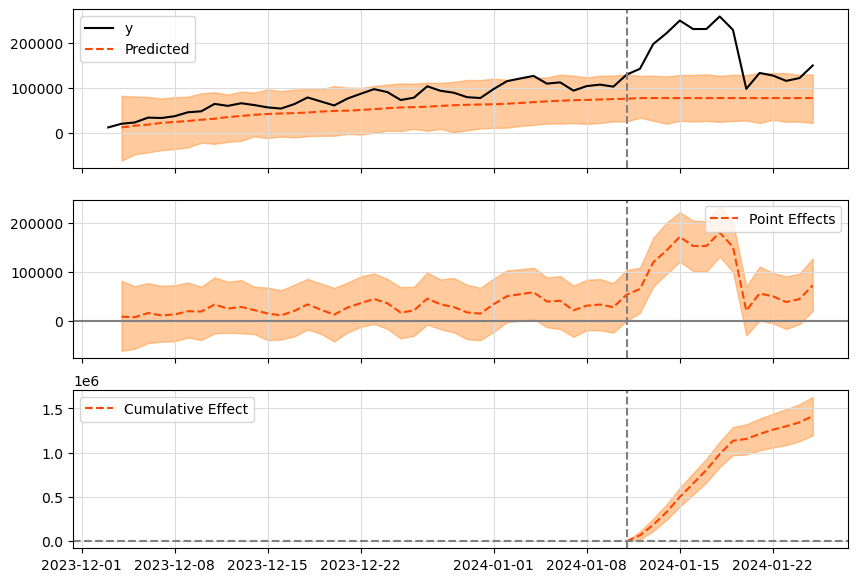

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    178577.58          2500086.0
Prediction (s.d.)         77612.86 (8018.09) 1086580.0 (112253.21)
95% CI                    [62404.67, 93835.0][873665.34, 1313689.93]

Absolute effect (s.d.)    100964.72 (8018.09)1413506.0 (112253.21)
95% CI                    [84742.58, 116172.91][1186396.07, 1626420.66]

Relative effect (s.d.)    130.09% (10.33%)   130.09% (10.33%)
95% CI                    [109.19%, 149.68%] [109.19%, 149.68%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))

views


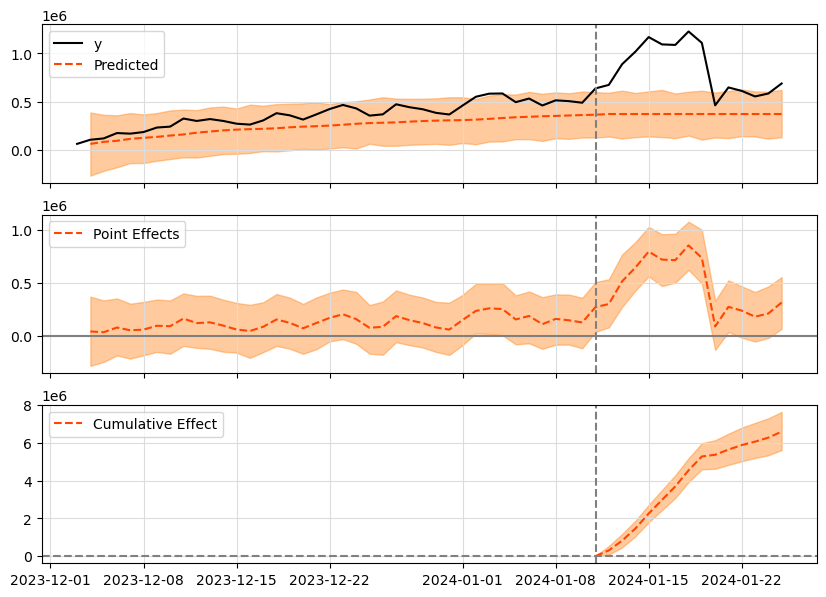

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    841797.56          11785166.0
Prediction (s.d.)         371188.81 (36462.8)5196643.5 (510479.17)
95% CI                    [301574.28, 444505.86][4222039.91, 6223081.92]

Absolute effect (s.d.)    470608.75 (36462.8)6588522.5 (510479.17)
95% CI                    [397291.7, 540223.29][5562084.08, 7563126.09]

Relative effect (s.d.)    126.78% (9.82%)    126.78% (9.82%)
95% CI                    [107.03%, 145.54%] [107.03%, 145.54%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))

users_feed


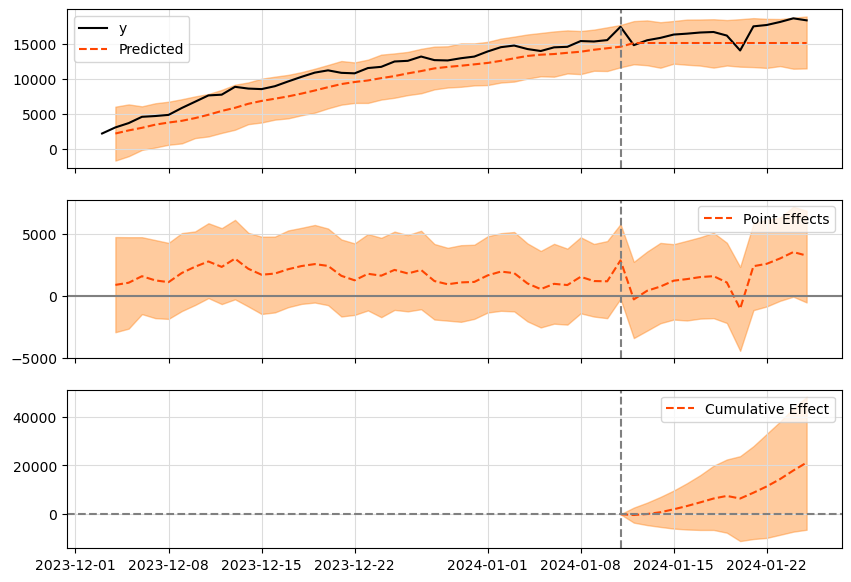

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16642.86           233000.0
Prediction (s.d.)         15132.56 (1034.97) 211855.84 (14489.64)
95% CI                    [13238.51, 17295.54][185339.2, 242137.57]

Absolute effect (s.d.)    1510.3 (1034.97)   21144.16 (14489.64)
95% CI                    [-652.68, 3404.34] [-9137.57, 47660.8]

Relative effect (s.d.)    9.98% (6.84%)      9.98% (6.84%)
95% CI                    [-4.31%, 22.5%]    [-4.31%, 22.5%]

Posterior tail-area probability p: 0.07
Posterior prob. of a causal effect: 93.01%

For more details run the command: print(impact.summary('report'))

new_feed_users


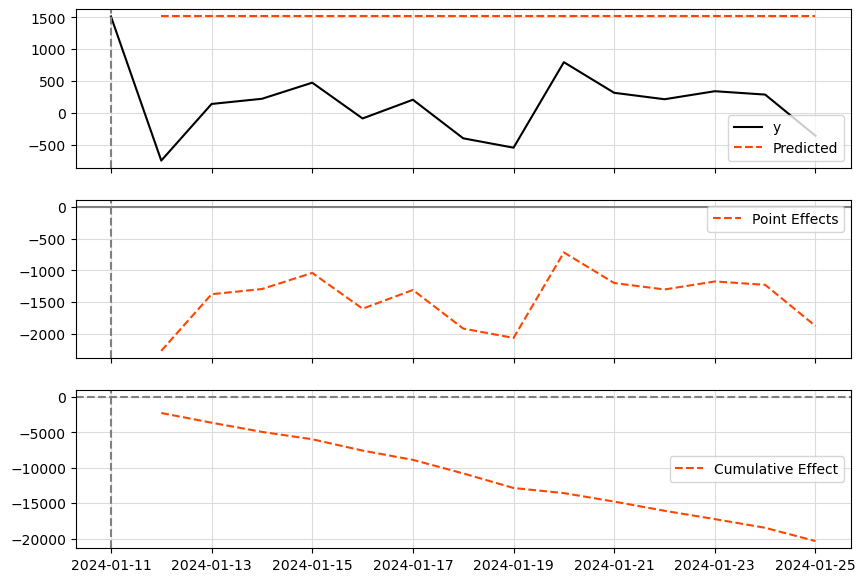

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    59.57              834.0
Prediction (s.d.)         1513.0 (nan)       21182.0 (nan)
95% CI                    [nan, nan]         [nan, nan]

Absolute effect (s.d.)    -1453.43 (nan)     -20348.0 (nan)
95% CI                    [nan, nan]         [nan, nan]

Relative effect (s.d.)    -96.06% (nan%)     -96.06% (nan%)
95% CI                    [nan%, nan%]       [nan%, nan%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))

users_mess


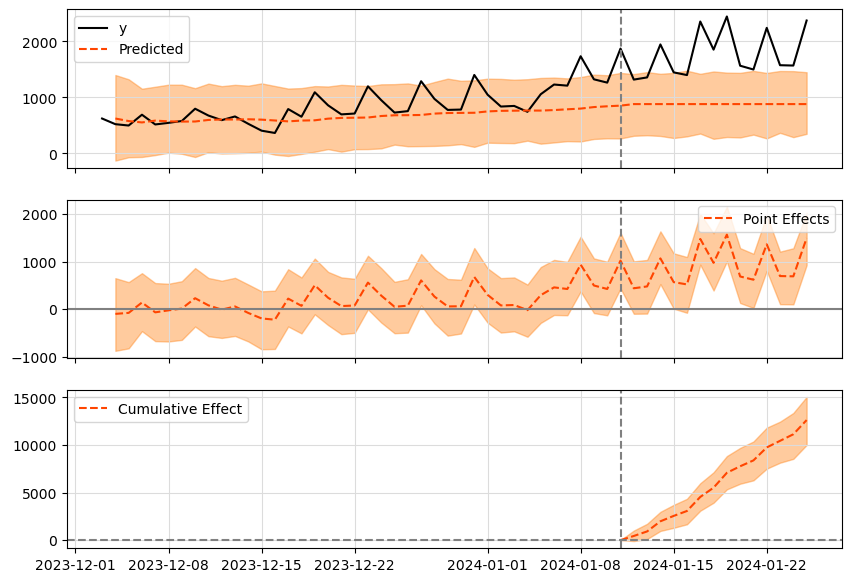

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1781.64            24943.0
Prediction (s.d.)         880.78 (90.53)     12330.93 (1267.38)
95% CI                    [701.07, 1055.93]  [9815.05, 14783.07]

Absolute effect (s.d.)    900.86 (90.53)     12612.07 (1267.38)
95% CI                    [725.71, 1080.57]  [10159.93, 15127.95]

Relative effect (s.d.)    102.28% (10.28%)   102.28% (10.28%)
95% CI                    [82.39%, 122.68%]  [82.39%, 122.68%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))

usersWithLikes_share


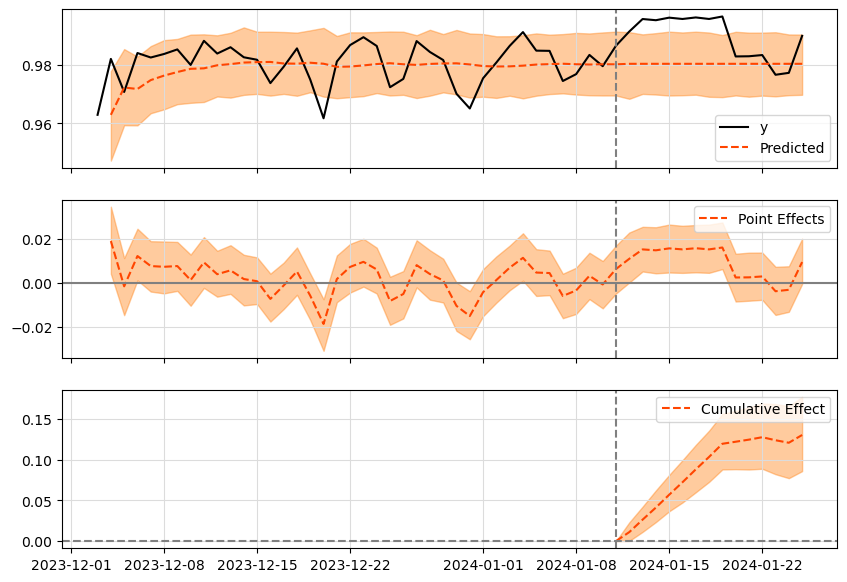

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.99               13.85
Prediction (s.d.)         0.98 (0.0)         13.72 (0.02)
95% CI                    [0.98, 0.98]       [13.68, 13.77]

Absolute effect (s.d.)    0.01 (0.0)         0.13 (0.02)
95% CI                    [0.01, 0.01]       [0.08, 0.18]

Relative effect (s.d.)    0.95% (0.18%)      0.95% (0.18%)
95% CI                    [0.6%, 1.29%]      [0.6%, 1.29%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))

posts


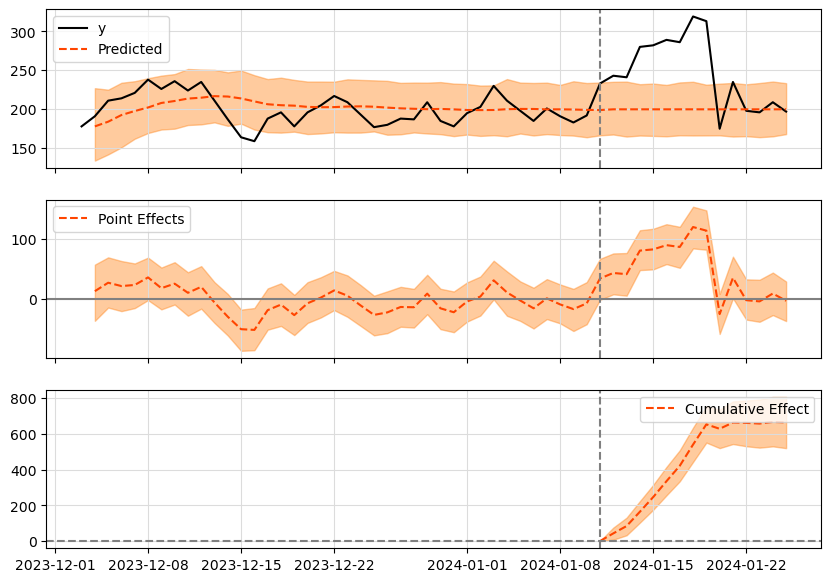

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    247.36             3463.0
Prediction (s.d.)         199.89 (5.25)      2798.51 (73.44)
95% CI                    [189.68, 210.24]   [2655.48, 2943.37]

Absolute effect (s.d.)    47.46 (5.25)       664.49 (73.44)
95% CI                    [37.12, 57.68]     [519.63, 807.52]

Relative effect (s.d.)    23.74% (2.62%)     23.74% (2.62%)
95% CI                    [18.57%, 28.86%]   [18.57%, 28.86%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))

new_posts


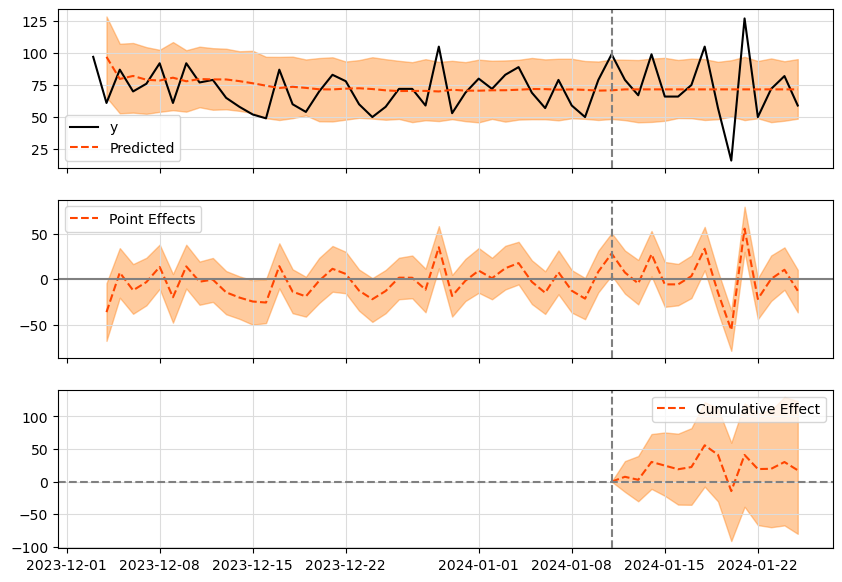

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    72.86              1020.0
Prediction (s.d.)         71.61 (3.82)       1002.59 (53.43)
95% CI                    [63.98, 78.94]     [895.78, 1105.22]

Absolute effect (s.d.)    1.24 (3.82)        17.41 (53.43)
95% CI                    [-6.09, 8.87]      [-85.22, 124.22]

Relative effect (s.d.)    1.74% (5.33%)      1.74% (5.33%)
95% CI                    [-8.5%, 12.39%]    [-8.5%, 12.39%]

Posterior tail-area probability p: 0.38
Posterior prob. of a causal effect: 62.04%

For more details run the command: print(impact.summary('report'))

CTR


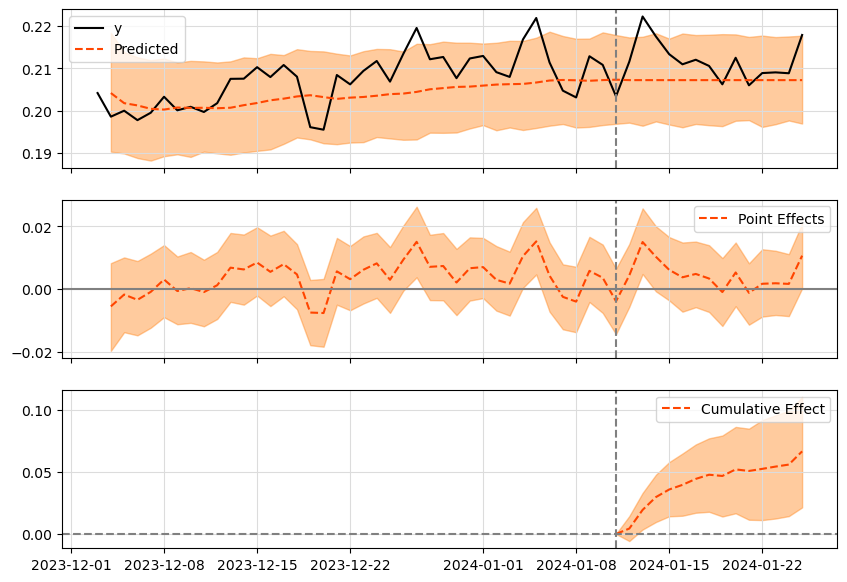

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               2.97
Prediction (s.d.)         0.21 (0.0)         2.9 (0.02)
95% CI                    [0.2, 0.21]        [2.86, 2.95]

Absolute effect (s.d.)    0.0 (0.0)          0.07 (0.02)
95% CI                    [0.0, 0.01]        [0.02, 0.11]

Relative effect (s.d.)    2.29% (0.81%)      2.29% (0.81%)
95% CI                    [0.69%, 3.88%]     [0.69%, 3.88%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.7%

For more details run the command: print(impact.summary('report'))

ER


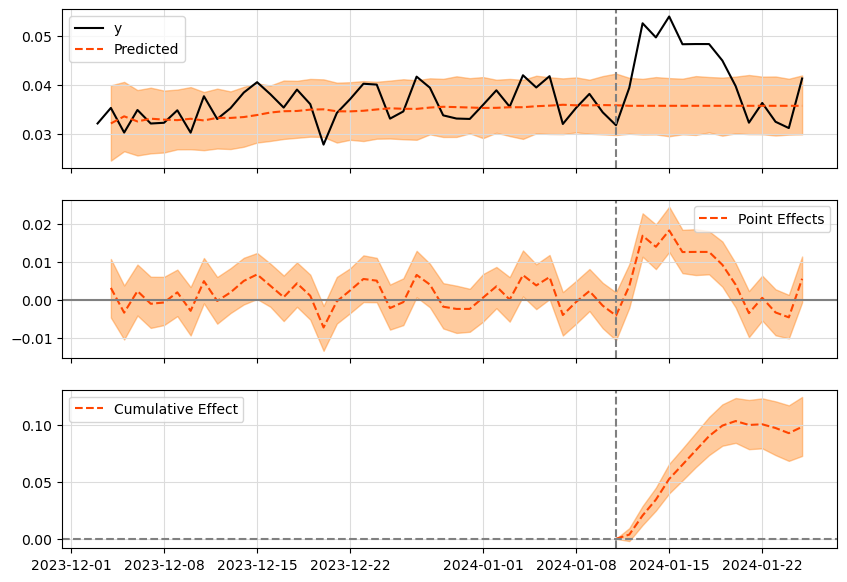

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.04               0.6
Prediction (s.d.)         0.04 (0.0)         0.5 (0.01)
95% CI                    [0.03, 0.04]       [0.47, 0.53]

Absolute effect (s.d.)    0.01 (0.0)         0.1 (0.01)
95% CI                    [0.01, 0.01]       [0.07, 0.12]

Relative effect (s.d.)    19.68% (2.68%)     19.68% (2.68%)
95% CI                    [14.42%, 24.94%]   [14.42%, 24.94%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))



In [167]:
pre_period = ['2023-12-03', '2024-01-11']       #drop anomaly at 2023-12-02, CTR
post_period = ['2024-01-12', '2024-01-25']
metrics = activity_causal.columns.tolist()

for i in metrics:
    text = '\033[1m' + i
    impact = CausalImpact(data=activity_causal[i], pre_period = pre_period, post_period = post_period)
    print(text)
    impact.plot()
    plt.show()
    print(impact.summary())
    print('')

CausalImpact model badly at metrics with trend.
We could try to solve this problem with TFP

likes


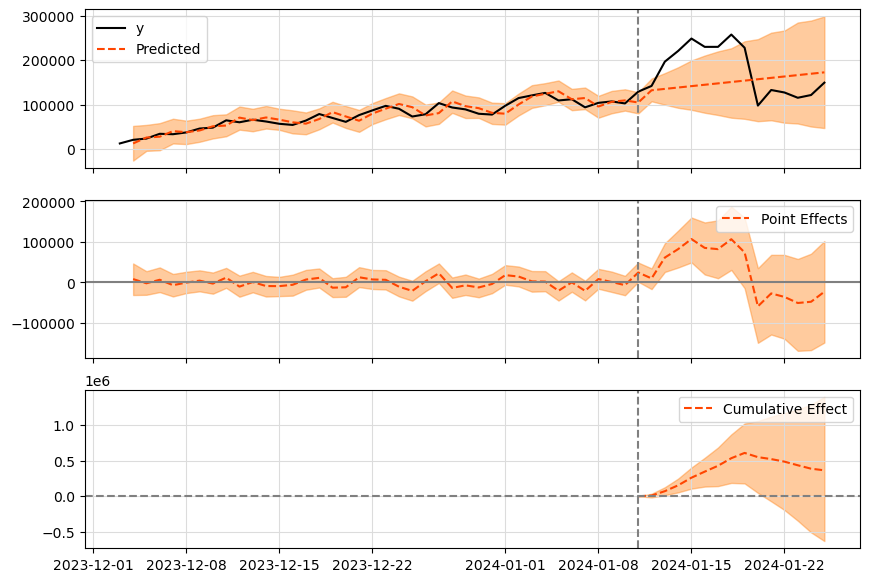

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    178577.58          2500086.0
Prediction (s.d.)         152583.5 (34669.85)2136169.0 (485377.87)
95% CI                    [82045.32, 217948.66][1148634.5, 3051281.2]

Absolute effect (s.d.)    25994.08 (34669.85)363917.0 (485377.87)
95% CI                    [-39371.08, 96532.25][-551195.2, 1351451.5]

Relative effect (s.d.)    17.04% (22.72%)    17.04% (22.72%)
95% CI                    [-25.8%, 63.27%]   [-25.8%, 63.27%]

Posterior tail-area probability p: 0.19
Posterior prob. of a causal effect: 80.72%

For more details run the command: print(impact.summary('report'))

views


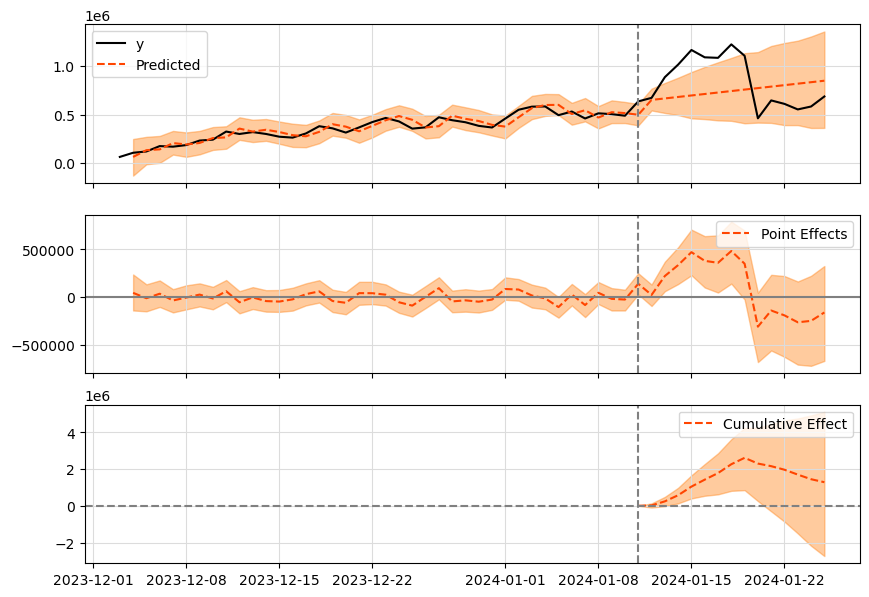

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    841797.56          11785166.0
Prediction (s.d.)         750108.5 (154409.74)10501519.0 (2161736.37)
95% CI                    [442495.57, 1047770.77][6194938.15, 14668790.77]

Absolute effect (s.d.)    91689.06 (154409.74)1283647.0 (2161736.37)
95% CI                    [-205973.21, 399301.99][-2883624.77, 5590227.85]

Relative effect (s.d.)    12.22% (20.58%)    12.22% (20.58%)
95% CI                    [-27.46%, 53.23%]  [-27.46%, 53.23%]

Posterior tail-area probability p: 0.24
Posterior prob. of a causal effect: 75.82%

For more details run the command: print(impact.summary('report'))

users_feed


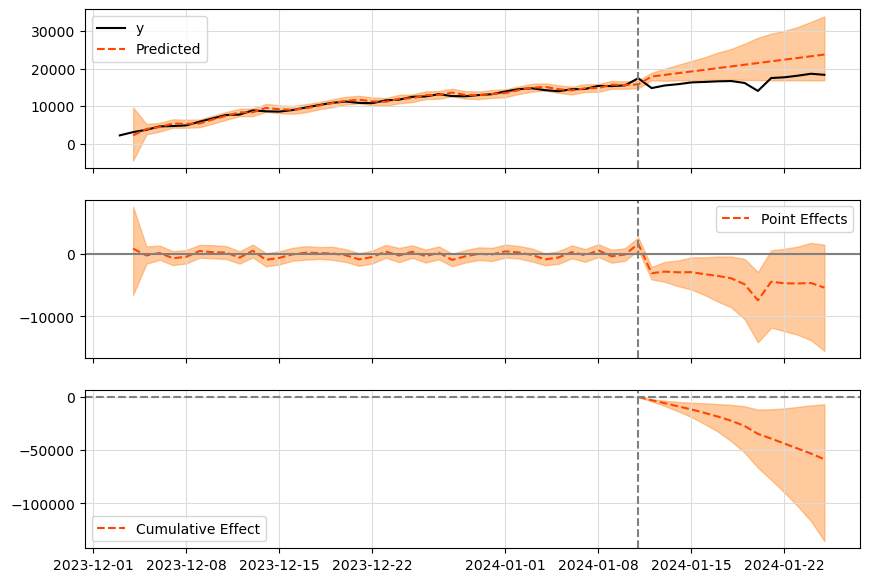

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16642.86           233000.0
Prediction (s.d.)         20830.75 (2152.0)  291630.5 (30127.98)
95% CI                    [17342.27, 25777.95][242791.72, 360891.27]

Absolute effect (s.d.)    -4187.89 (2152.0)  -58630.5 (30127.98)
95% CI                    [-9135.09, -699.41][-127891.27, -9791.72]

Relative effect (s.d.)    -20.1% (10.33%)    -20.1% (10.33%)
95% CI                    [-43.85%, -3.36%]  [-43.85%, -3.36%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 98.9%

For more details run the command: print(impact.summary('report'))

new_feed_users


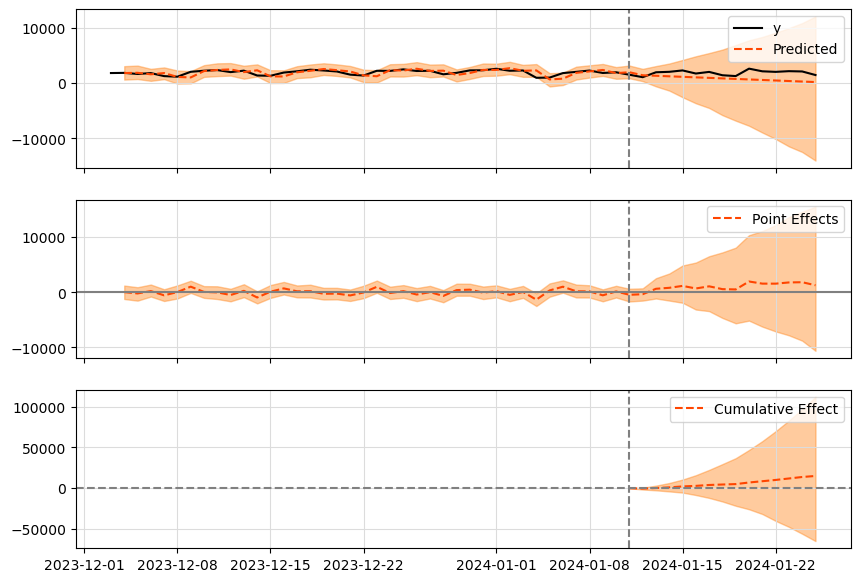

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1879.57            26314.0
Prediction (s.d.)         801.95 (3016.38)   11227.34 (42229.3)
95% CI                    [-5682.15, 6141.84][-79550.09, 85985.76]

Absolute effect (s.d.)    1077.62 (3016.38)  15086.66 (42229.3)
95% CI                    [-4262.27, 7561.72][-59671.76, 105864.09]

Relative effect (s.d.)    134.37% (376.13%)  134.37% (376.13%)
95% CI                    [-531.49%, 942.91%][-531.49%, 942.91%]

Posterior tail-area probability p: 0.33
Posterior prob. of a causal effect: 66.63%

For more details run the command: print(impact.summary('report'))

users_mess


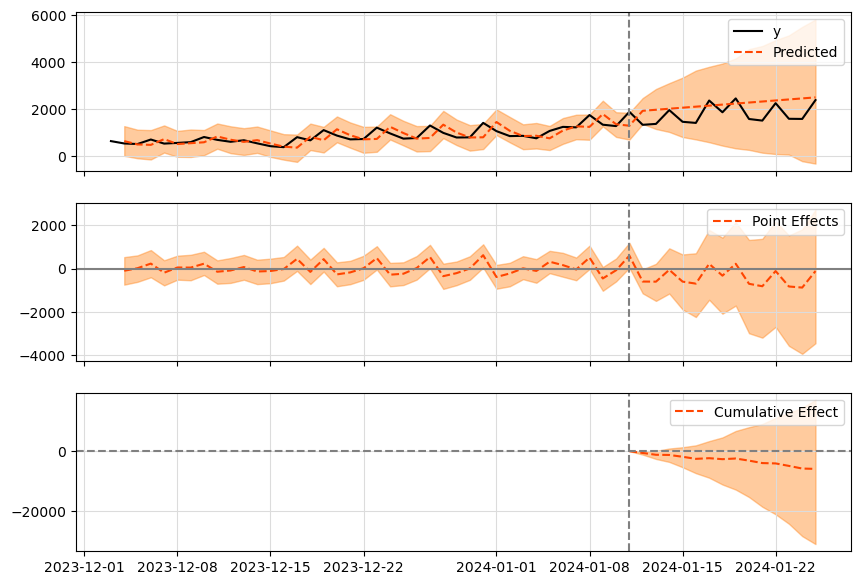

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1781.64            24943.0
Prediction (s.d.)         2202.36 (809.98)   30832.99 (11339.78)
95% CI                    [812.39, 3987.47]  [11373.46, 55824.61]

Absolute effect (s.d.)    -420.71 (809.98)   -5889.99 (11339.78)
95% CI                    [-2205.83, 969.25] [-30881.61, 13569.54]

Relative effect (s.d.)    -19.1% (36.78%)    -19.1% (36.78%)
95% CI                    [-100.16%, 44.01%] [-100.16%, 44.01%]

Posterior tail-area probability p: 0.3
Posterior prob. of a causal effect: 69.93%

For more details run the command: print(impact.summary('report'))

usersWithLikes_share


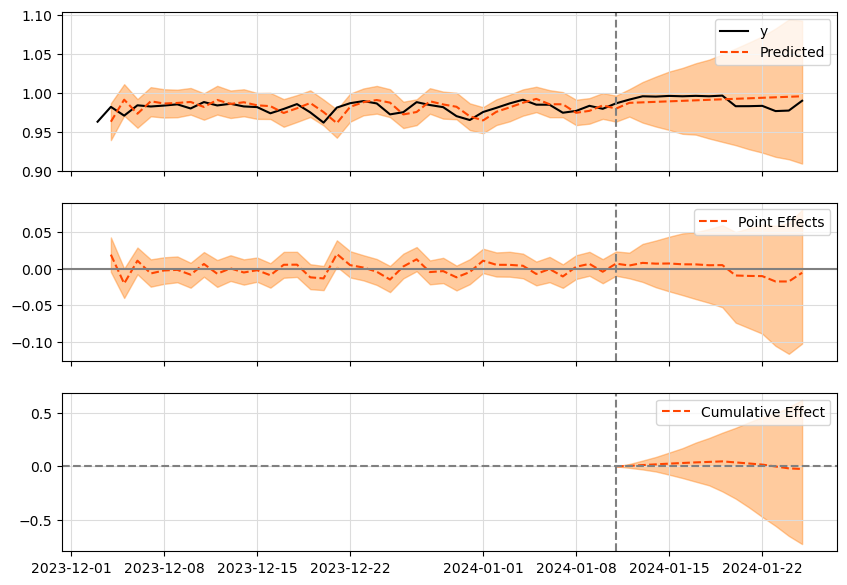

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.99               13.85
Prediction (s.d.)         0.99 (0.03)        13.88 (0.38)
95% CI                    [0.94, 1.05]       [13.19, 14.68]

Absolute effect (s.d.)    -0.0 (0.03)        -0.02 (0.38)
95% CI                    [-0.06, 0.05]      [-0.83, 0.66]

Relative effect (s.d.)    -0.18% (2.74%)     -0.18% (2.74%)
95% CI                    [-5.96%, 4.79%]    [-5.96%, 4.79%]

Posterior tail-area probability p: 0.48
Posterior prob. of a causal effect: 51.85%

For more details run the command: print(impact.summary('report'))

posts


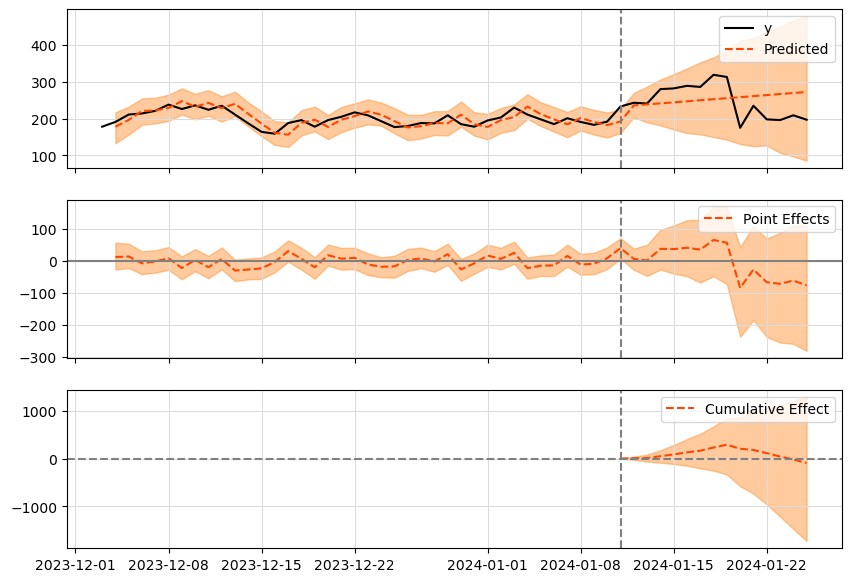

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    247.36             3463.0
Prediction (s.d.)         254.07 (62.71)     3556.96 (877.87)
95% CI                    [151.63, 397.43]   [2122.85, 5564.05]

Absolute effect (s.d.)    -6.71 (62.71)      -93.96 (877.87)
95% CI                    [-150.08, 95.72]   [-2101.05, 1340.15]

Relative effect (s.d.)    -2.64% (24.68%)    -2.64% (24.68%)
95% CI                    [-59.07%, 37.68%]  [-59.07%, 37.68%]

Posterior tail-area probability p: 0.49
Posterior prob. of a causal effect: 50.75%

For more details run the command: print(impact.summary('report'))

new_posts


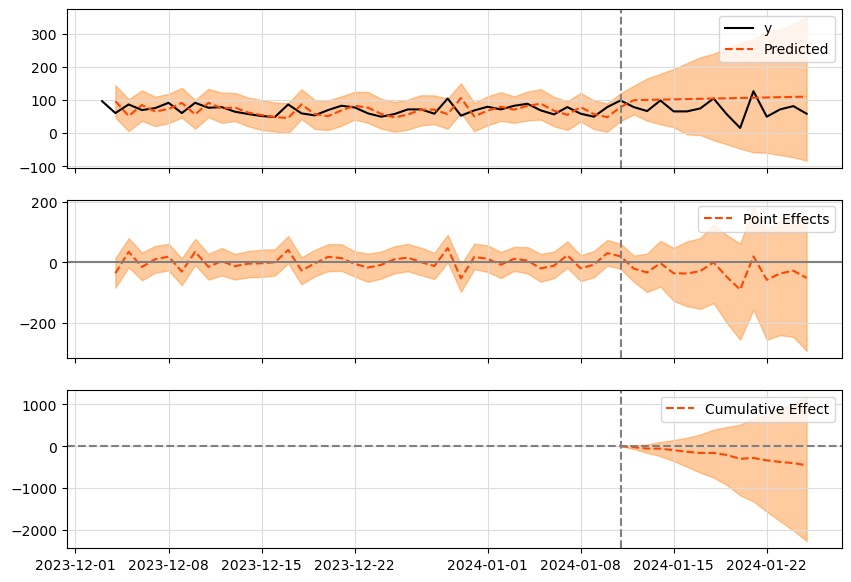

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    72.86              1020.0
Prediction (s.d.)         105.23 (70.58)     1473.27 (988.17)
95% CI                    [-18.66, 258.02]   [-261.29, 3612.27]

Absolute effect (s.d.)    -32.38 (70.58)     -453.27 (988.17)
95% CI                    [-185.16, 91.52]   [-2592.27, 1281.29]

Relative effect (s.d.)    -30.77% (67.07%)   -30.77% (67.07%)
95% CI                    [-175.95%, 86.97%] [-175.95%, 86.97%]

Posterior tail-area probability p: 0.29
Posterior prob. of a causal effect: 71.33%

For more details run the command: print(impact.summary('report'))

CTR


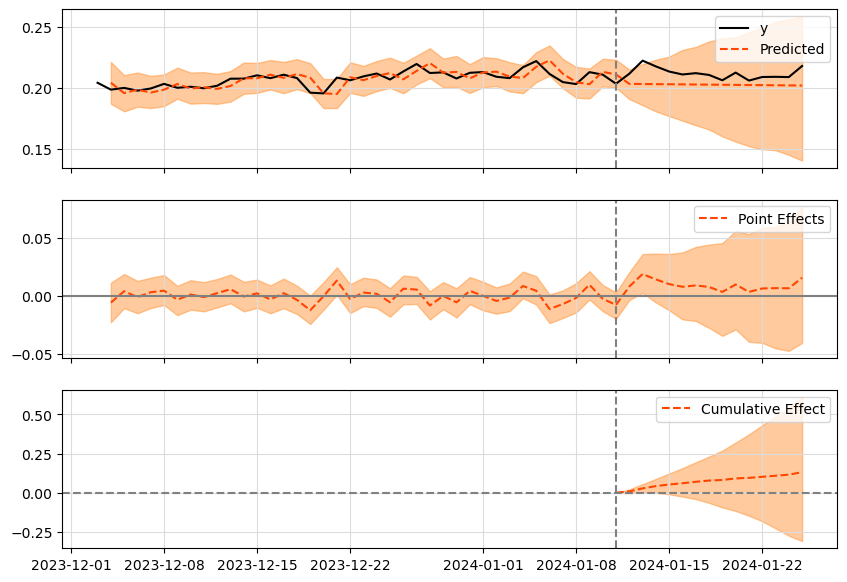

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               2.97
Prediction (s.d.)         0.2 (0.02)         2.84 (0.24)
95% CI                    [0.17, 0.23]       [2.35, 3.28]

Absolute effect (s.d.)    0.01 (0.02)        0.13 (0.24)
95% CI                    [-0.02, 0.04]      [-0.32, 0.62]

Relative effect (s.d.)    4.61% (8.39%)      4.61% (8.39%)
95% CI                    [-11.19%, 21.71%]  [-11.19%, 21.71%]

Posterior tail-area probability p: 0.28
Posterior prob. of a causal effect: 72.03%

For more details run the command: print(impact.summary('report'))

ER


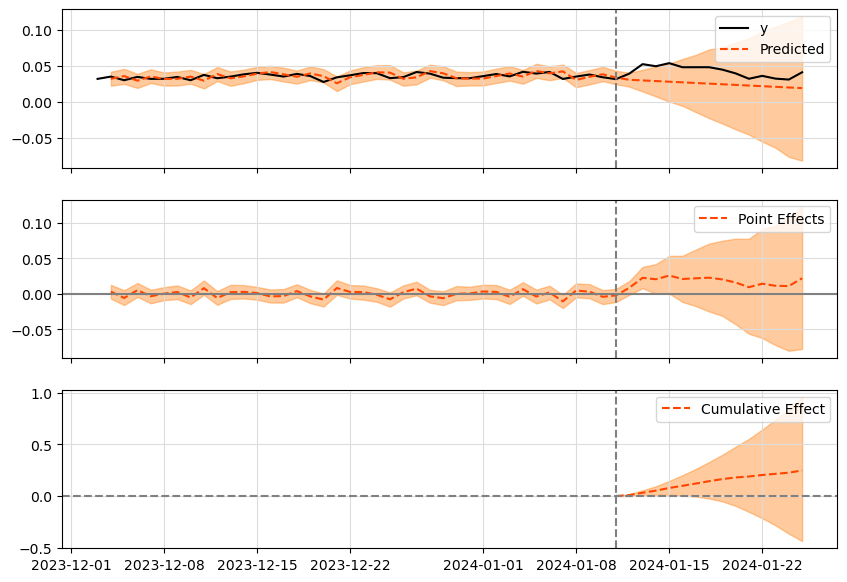

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.04               0.6
Prediction (s.d.)         0.03 (0.03)        0.35 (0.38)
95% CI                    [-0.03, 0.07]      [-0.45, 1.03]

Absolute effect (s.d.)    0.02 (0.03)        0.25 (0.38)
95% CI                    [-0.03, 0.07]      [-0.43, 1.05]

Relative effect (s.d.)    70.26% (107.26%)   70.26% (107.26%)
95% CI                    [-122.52%, 297.92%][-122.52%, 297.92%]

Posterior tail-area probability p: 0.2
Posterior prob. of a causal effect: 80.22%

For more details run the command: print(impact.summary('report'))



In [204]:
pre_period = ['2023-12-03', '2024-01-11']       #drop anomaly at 2023-12-02, CTR
post_period = ['2024-01-12', '2024-01-25']
metrics = activity_causal.columns.tolist()
metric_index = 0

for i in metrics:
    data = activity_causal.astype(np.float32)

    #standartization
    norm_data, _ = causalimpact.misc.standardize(data)
    obs_data = norm_data.iloc[:41, metric_index]                        #period previous the campaign
    trend_component = tfp.sts.LocalLinearTrend(observed_time_series=obs_data)
    metric_index+= 1

    #causal model
    text = '\033[1m' + i
    impact = CausalImpact(data=activity_causal[i], pre_period = pre_period, post_period = post_period, model=trend_component)
    print(text)
    impact.plot()
    plt.show()
    print(impact.summary())
    print('')

CausalImpact model with trend and second predict metric

.kjf.kgjzdgjkzsjf


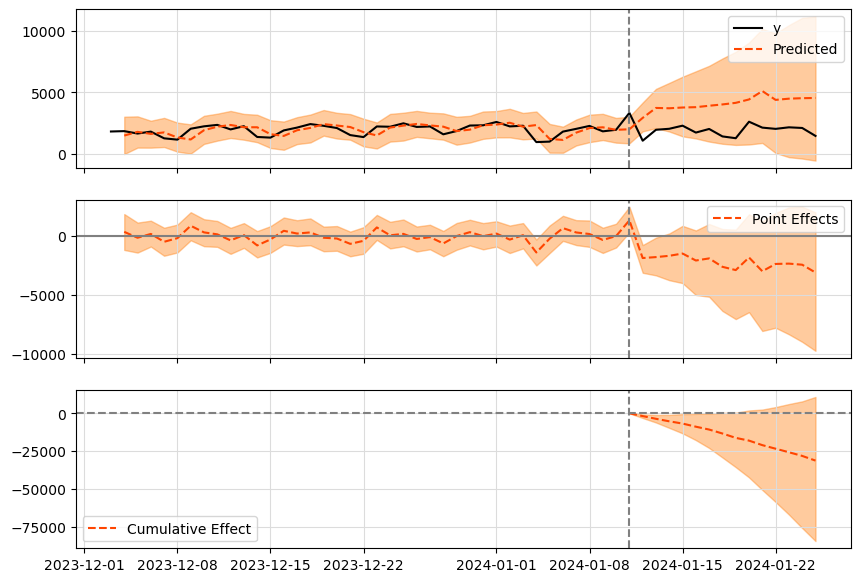

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1879.57            26314.0
Prediction (s.d.)         4108.09 (1531.63)  57513.31 (21442.75)
95% CI                    [1375.03, 7378.89] [19250.39, 103304.45]

Absolute effect (s.d.)    -2228.52 (1531.63) -31199.31 (21442.75)
95% CI                    [-5499.32, 504.54] [-76990.45, 7063.61]

Relative effect (s.d.)    -54.25% (37.28%)   -54.25% (37.28%)
95% CI                    [-133.87%, 12.28%] [-133.87%, 12.28%]

Posterior tail-area probability p: 0.06
Posterior prob. of a causal effect: 94.01%

For more details run the command: print(impact.summary('report'))


In [6]:
pre_period = ['2023-12-03', '2024-01-11']       #drop anomaly at 2023-12-02, CTR
post_period = ['2024-01-12', '2024-01-25']

causality = activity[['day', 'new_feed_users', 'users_feed']]
data = causality.drop('day', axis=1).astype(np.float32)

#standartization
norm_data, _ = causalimpact.misc.standardize(data)
obs_data = norm_data.iloc[:41, 0]                        #period previous the campaign
trend_component = tfp.sts.LocalLinearTrend(observed_time_series=obs_data)

#new regression element
linear_reg = tfp.sts.LinearRegression(design_matrix=norm_data.iloc[:54, 1].values.reshape(-1, 1).astype(np.float32))

#join 2 metrics
custom_model = tfp.sts.Sum([trend_component, linear_reg], observed_time_series=obs_data)

#causal model
reg_custom = CausalImpact(data=causality.set_index('day'), pre_period=pre_period, post_period=post_period, model=custom_model)
print('New users relative all active users')
reg_custom.plot()
plt.show()
print(reg_custom.summary())

New users relative all active users


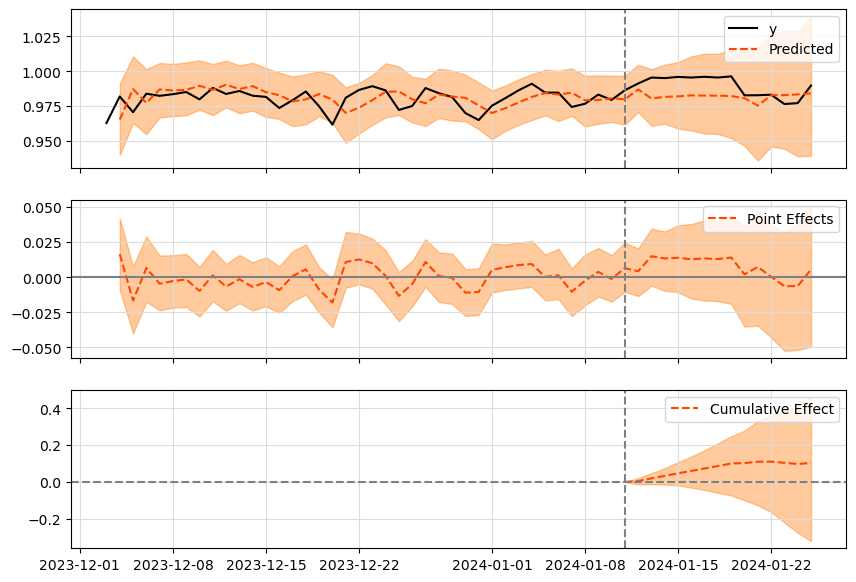

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.99               13.85
Prediction (s.d.)         0.98 (0.02)        13.75 (0.21)
95% CI                    [0.96, 1.02]       [13.39, 14.22]

Absolute effect (s.d.)    0.01 (0.02)        0.1 (0.21)
95% CI                    [-0.03, 0.03]      [-0.37, 0.47]

Relative effect (s.d.)    0.75% (1.55%)      0.75% (1.55%)
95% CI                    [-2.69%, 3.39%]    [-2.69%, 3.39%]

Posterior tail-area probability p: 0.26
Posterior prob. of a causal effect: 74.03%

For more details run the command: print(impact.summary('report'))


In [11]:
pre_period = ['2023-12-03', '2024-01-11']       #drop anomaly at 2023-12-02, CTR
post_period = ['2024-01-12', '2024-01-25']

causality = activity[['day', 'usersWithLikes_share', 'users_feed']]
data = causality.drop('day', axis=1).astype(np.float32)

#standartization
norm_data, _ = causalimpact.misc.standardize(data)
obs_data = norm_data.iloc[:41, 0]                        #period previous the campaign
trend_component = tfp.sts.LocalLinearTrend(observed_time_series=obs_data)

#new regression element
linear_reg = tfp.sts.LinearRegression(design_matrix=norm_data.iloc[:54, 1].values.reshape(-1, 1).astype(np.float32))

#join 2 metrics
custom_model = tfp.sts.Sum([trend_component, linear_reg], observed_time_series=obs_data)

#causal model
reg_custom = CausalImpact(data=causality.set_index('day'), pre_period=pre_period, post_period=post_period, model=custom_model)
print('Users with likes relative all active users')
reg_custom.plot()
plt.show()
print(reg_custom.summary())

CTR relative likes


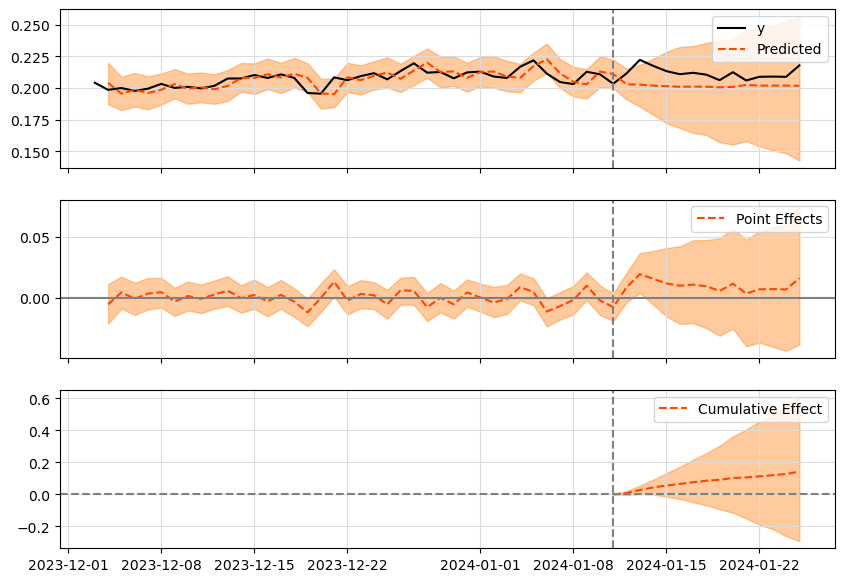

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               2.97
Prediction (s.d.)         0.2 (0.02)         2.82 (0.23)
95% CI                    [0.17, 0.23]       [2.36, 3.28]

Absolute effect (s.d.)    0.01 (0.02)        0.14 (0.23)
95% CI                    [-0.02, 0.04]      [-0.31, 0.61]

Relative effect (s.d.)    5.08% (8.32%)      5.08% (8.32%)
95% CI                    [-10.97%, 21.64%]  [-10.97%, 21.64%]

Posterior tail-area probability p: 0.26
Posterior prob. of a causal effect: 74.33%

For more details run the command: print(impact.summary('report'))


In [12]:
pre_period = ['2023-12-03', '2024-01-11']       #drop anomaly at 2023-12-02, CTR
post_period = ['2024-01-12', '2024-01-25']

causality = activity[['day', 'CTR', 'likes']]
data = causality.drop('day', axis=1).astype(np.float32)

#standartization
norm_data, _ = causalimpact.misc.standardize(data)
obs_data = norm_data.iloc[:41, 0]                        #period previous the campaign
trend_component = tfp.sts.LocalLinearTrend(observed_time_series=obs_data)

#new regression element
linear_reg = tfp.sts.LinearRegression(design_matrix=norm_data.iloc[:54, 1].values.reshape(-1, 1).astype(np.float32))

#join 2 metrics
custom_model = tfp.sts.Sum([trend_component, linear_reg], observed_time_series=obs_data)

#causal model
reg_custom = CausalImpact(data=causality.set_index('day'), pre_period=pre_period, post_period=post_period, model=custom_model)
print('CTR relative likes')
reg_custom.plot()
plt.show()
print(reg_custom.summary())

New posts amount relative all active users


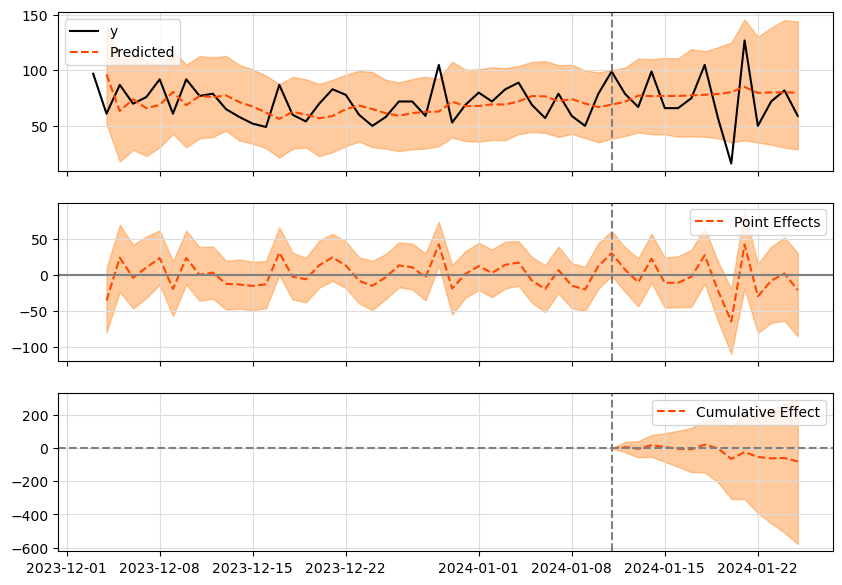

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    72.86              1020.0
Prediction (s.d.)         78.56 (14.2)       1099.84 (198.81)
95% CI                    [50.9, 106.57]     [712.63, 1491.94]

Absolute effect (s.d.)    -5.7 (14.2)        -79.84 (198.81)
95% CI                    [-33.71, 21.96]    [-471.94, 307.37]

Relative effect (s.d.)    -7.26% (18.08%)    -7.26% (18.08%)
95% CI                    [-42.91%, 27.95%]  [-42.91%, 27.95%]

Posterior tail-area probability p: 0.37
Posterior prob. of a causal effect: 62.74%

For more details run the command: print(impact.summary('report'))


In [13]:
pre_period = ['2023-12-03', '2024-01-11']       #drop anomaly at 2023-12-02, CTR
post_period = ['2024-01-12', '2024-01-25']

causality = activity[['day', 'new_posts', 'users_feed']]
data = causality.drop('day', axis=1).astype(np.float32)

#standartization
norm_data, _ = causalimpact.misc.standardize(data)
obs_data = norm_data.iloc[:41, 0]                        #period previous the campaign
trend_component = tfp.sts.LocalLinearTrend(observed_time_series=obs_data)

#new regression element
linear_reg = tfp.sts.LinearRegression(design_matrix=norm_data.iloc[:54, 1].values.reshape(-1, 1).astype(np.float32))

#join 2 metrics
custom_model = tfp.sts.Sum([trend_component, linear_reg], observed_time_series=obs_data)

#causal model
reg_custom = CausalImpact(data=causality.set_index('day'), pre_period=pre_period, post_period=post_period, model=custom_model)
print('New posts amount relative all active users')
reg_custom.plot()
plt.show()
print(reg_custom.summary())